In [7]:
# load corpus dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_from_disk
from src.data.create_corpus_dataset import create_dataset, DatasetConfig, UtteranceType, DatasetSplitType
from src.data.dataset_splits import create_splits_from_corpus_dataset
from collections import defaultdict

from src.features.build_features import filter_queries_for_few_shot_setting, filter_passages_for_few_shot_setting

# load dataset
dataset_folder = "../../data/processed/with_context"
dataset_path = os.path.join(dataset_folder, "corpus_dataset_v2")

if not os.path.exists(dataset_path):
    # Beispiel zum Erstellen eines Datensatzes. Mögliche Optionen von DatasetConfig sind im DocString beschrieben.
    create_dataset(
        DatasetConfig(
            dataset_path=dataset_path,
            project_dir="../../",
            utterance_type=UtteranceType.User,
            eval_size=0.5,
            validation_test_ratio=0.5
        )
    )

# Beispiel zum Laden des Datensatzes + collate_function des DataLoaders um dynamisch ein Subset der negative passages zu laden.
corpus_dataset = load_from_disk(dataset_path)
# load split dataset
in_distribution_split = create_splits_from_corpus_dataset(corpus_dataset=corpus_dataset,
                                                          dataset_split_type=DatasetSplitType.InDistribution,
                                                          save_folder=dataset_folder,
                                                          dataset_save_name="dataset_in_distribution")

Filter: 100%|██████████| 2772/2772 [00:00<00:00, 327565.52 examples/s]
/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/data/dataset_splits.py:109: UserWarning: Overlapping texts between train and test (but no overlapping query ids, so theses are not the same queries): 1
Example texts: ['Sicherheit']
  warnings.warn(
Saving the dataset (1/1 shards): 100%|██████████| 417/417 [00:00<00:00, 118369.30 examples/s]


In [8]:
[p for p in corpus_dataset["queries"] if "NZ.K4-1" in p["labels"]]

[]

In [9]:
# Processing Features
num_shots_queries = 1
num_shots_passages = 1

train_split = in_distribution_split["train"]
eval_split = in_distribution_split["validation"]
test_split = in_distribution_split["test"]

# few-shots queries
train_split = filter_queries_for_few_shot_setting(train_split, num_shots_queries)


# few_shots passages
train_split = filter_passages_for_few_shot_setting(train_split, num_shots_passages)


in_distribution_split["train"] = train_split


Map: 100%|██████████| 217/217 [00:00<00:00, 16662.96 examples/s]


split,test,train,validation
label,,,
NZ.K10,23.0,3.0,25.0
Z.K7,12.0,2.0,25.0
Z.K1,9.0,2.0,20.0
Z.P5,8.0,1.0,6.0
Z.P6,7.0,1.0,9.0
...,...,...,...
Z.K1-2,0.0,1.0,0.0
Z.K3-1-1,0.0,1.0,0.0
NZ.K1,0.0,1.0,0.0


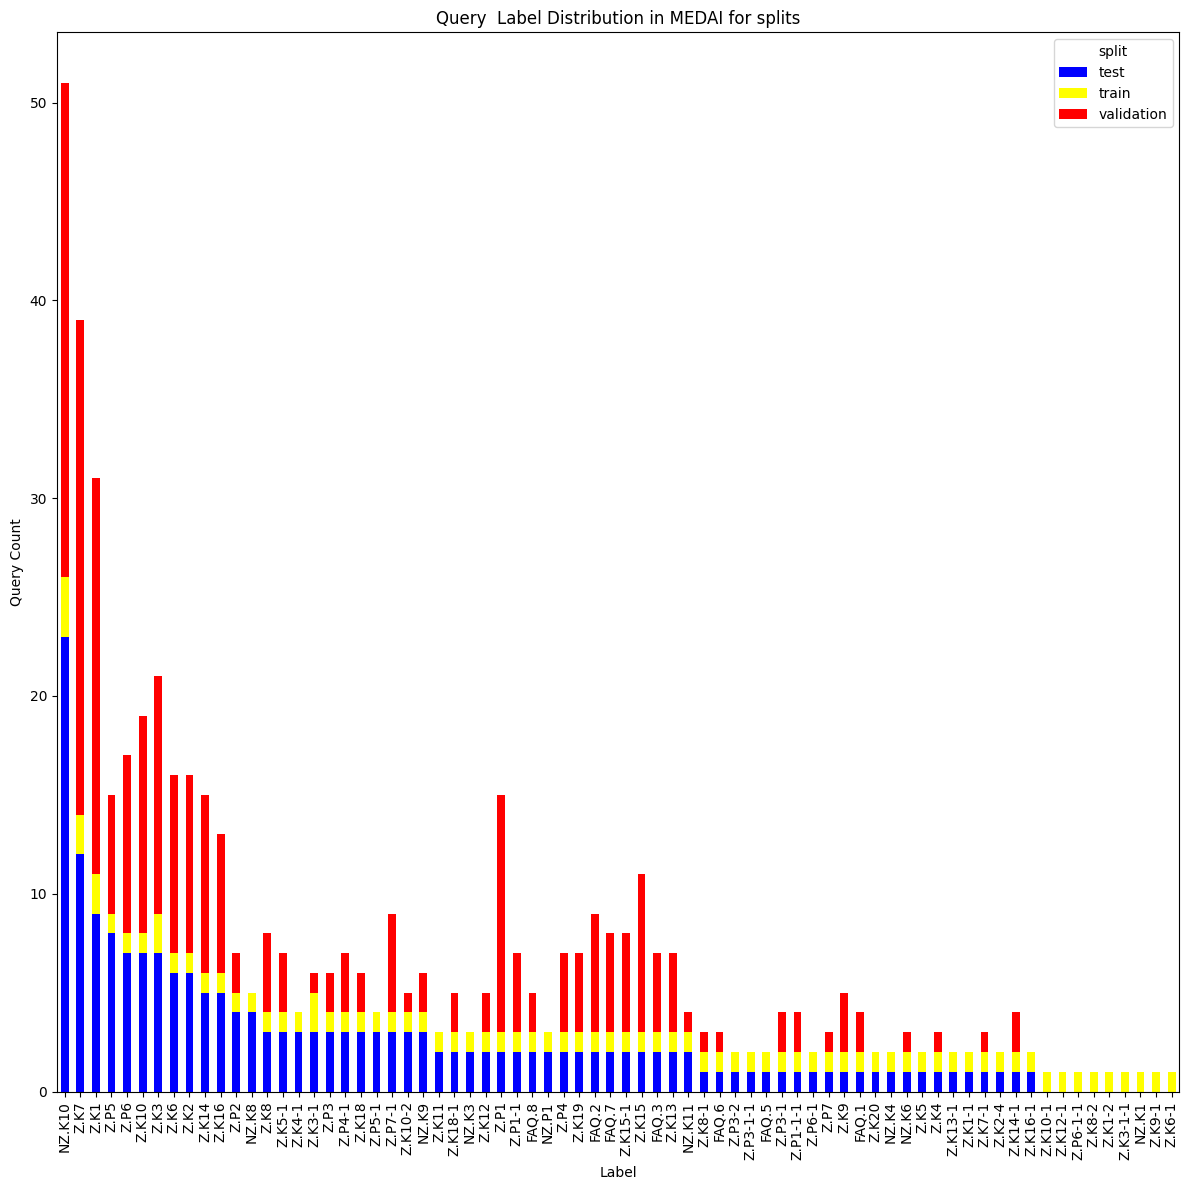

split,test,train,validation
label,,,
Z.P4-1,4.0,1.0,4.0
Z.P1-1,4.0,3.0,6.0
Z.P1,4.0,1.0,3.0
Z.K2,3.0,1.0,2.0
Z.P8,3.0,1.0,1.0
NZ.K10,3.0,1.0,2.0
Z.P3-1-1,3.0,1.0,0.0
Z.K9,3.0,1.0,0.0
Z.K3-2,3.0,1.0,0.0


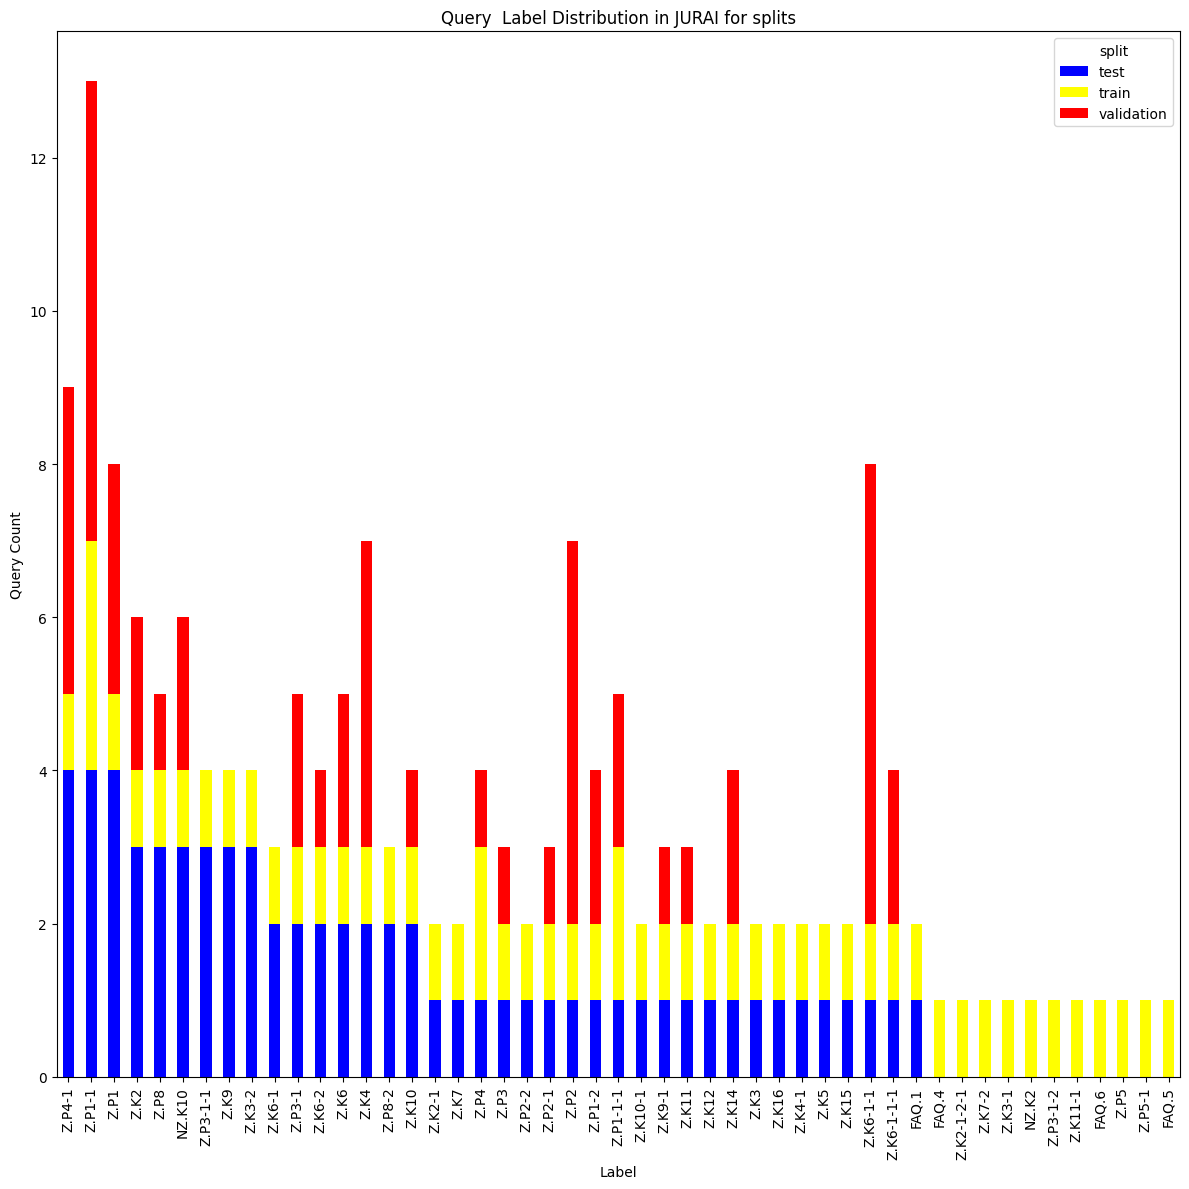

split,test,train,validation
label,,,
Z.P11,14.0,2.0,19.0
Z.C3,7.0,1.0,9.0
Z.C6,5.0,1.0,3.0
Z.P1,4.0,1.0,1.0
Z.P6-1,4.0,1.0,2.0
...,...,...,...
Z.P12-1,1.0,1.0,0.0
Z.C5-1-1,0.0,1.0,0.0
Z.C9,0.0,1.0,0.0


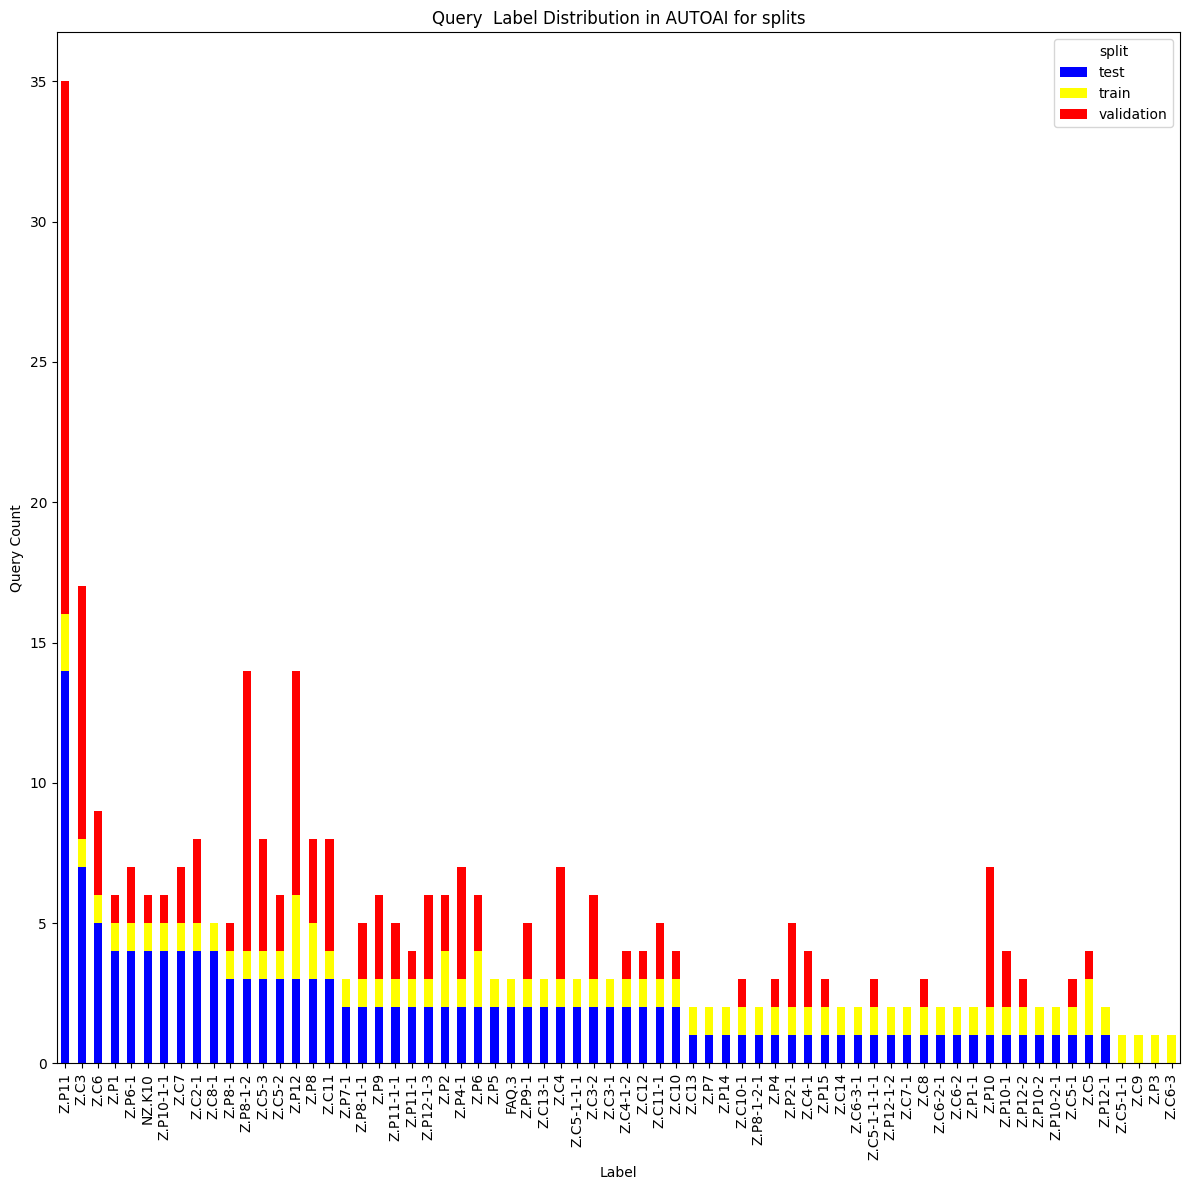

split,test,train,validation
label,,,
Z.P1,2.0,1.0,2.0
Z.K9,2.0,1.0,0.0
Z.P5,2.0,1.0,0.0
Z.K3,2.0,1.0,1.0
Z.K5,2.0,1.0,2.0
Z.P2,2.0,1.0,3.0
Z.P9,1.0,1.0,0.0
Z.P6,1.0,1.0,1.0
Z.P4,1.0,1.0,0.0


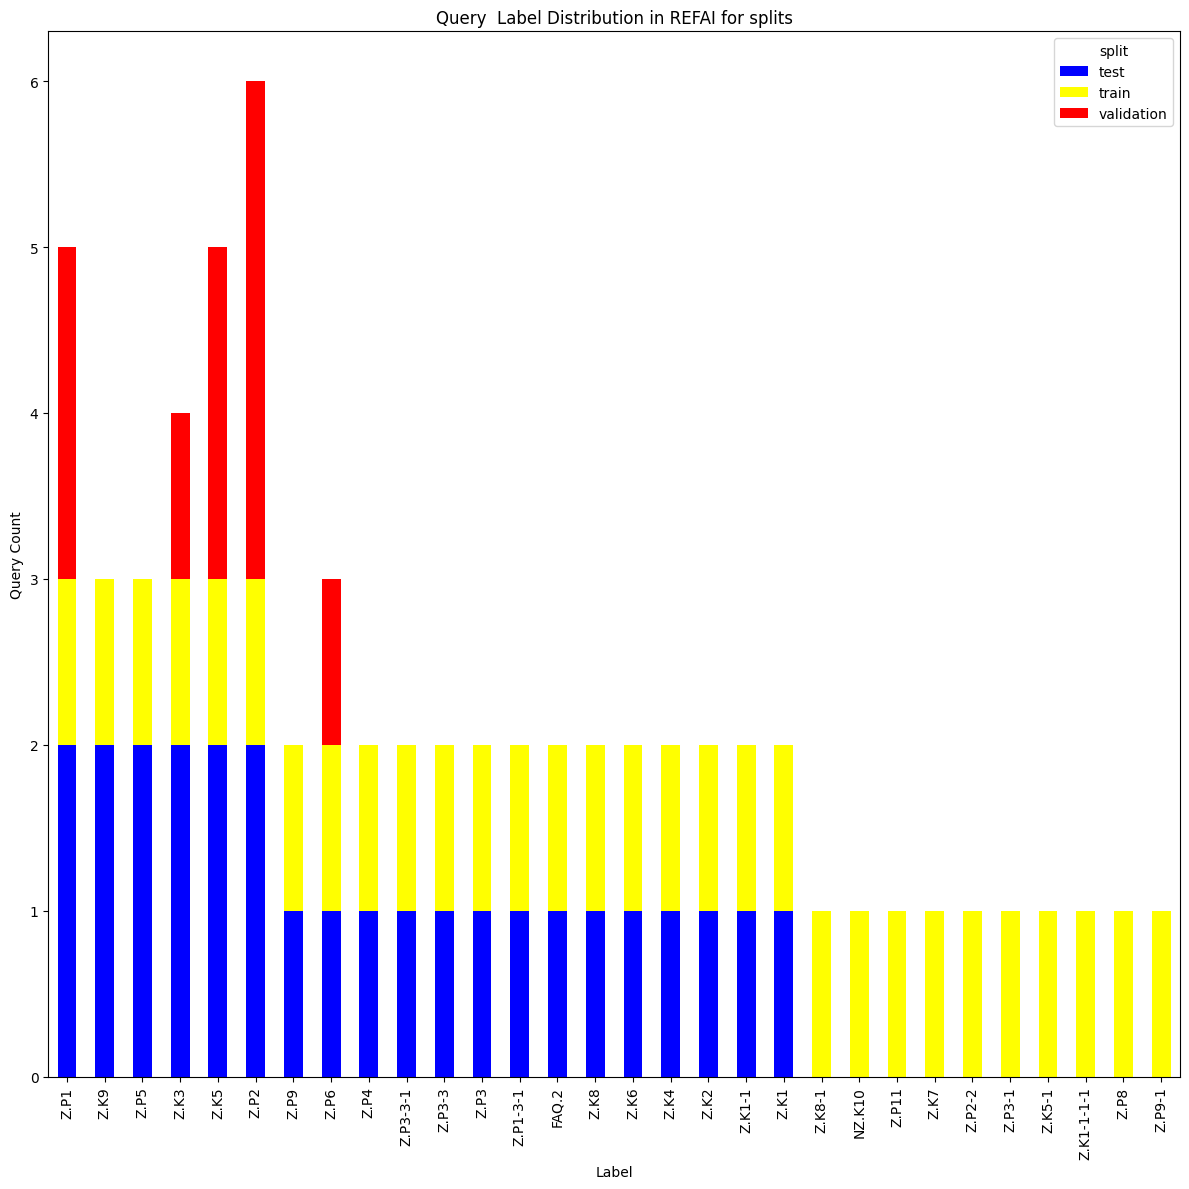

In [10]:
# Count labels per scenario and split for queries
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for query in in_distribution_split[split]["queries"]:
        scenario = query["discussion_scenario"]
        for label in query["labels"]:
            label_counts[split][scenario][label] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

df = pd.DataFrame(records)

# Plot stacked bar chart per scenario
scenarios = df["scenario"].unique()
for scenario in scenarios:
    df_scenario = df[df["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0).sort_values("test", ascending=False)
    display(pivot_df)
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 12))
    plt.title(f"Query  Label Distribution in {scenario} for splits")
    plt.ylabel("Query Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


split,test,train,validation
label,,,
NZ.K4,24,1,24
Z.K19-1,24,1,24
Z.K8-2,23,1,23
Z.K1-2,23,1,23
NZ.K1,23,1,23


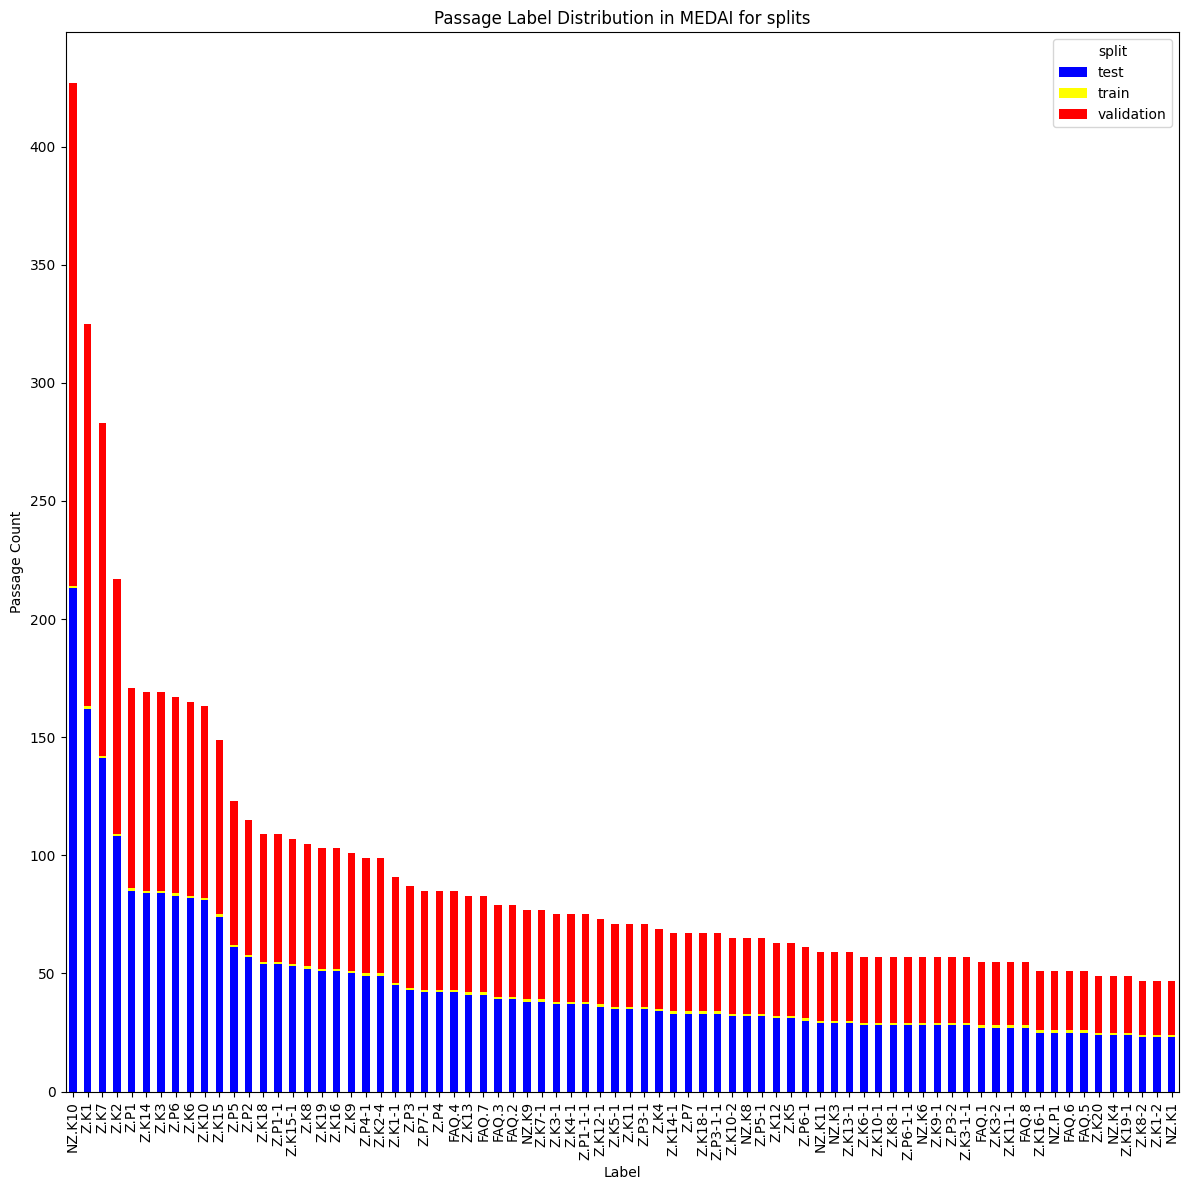

split,test,train,validation
label,,,
Z.K8-1,22,1,22
Z.K13-1,22,1,22
Z.K15-1,22,1,22
Z.P2-2-1,22,1,22
Z.K14-1,22,1,22


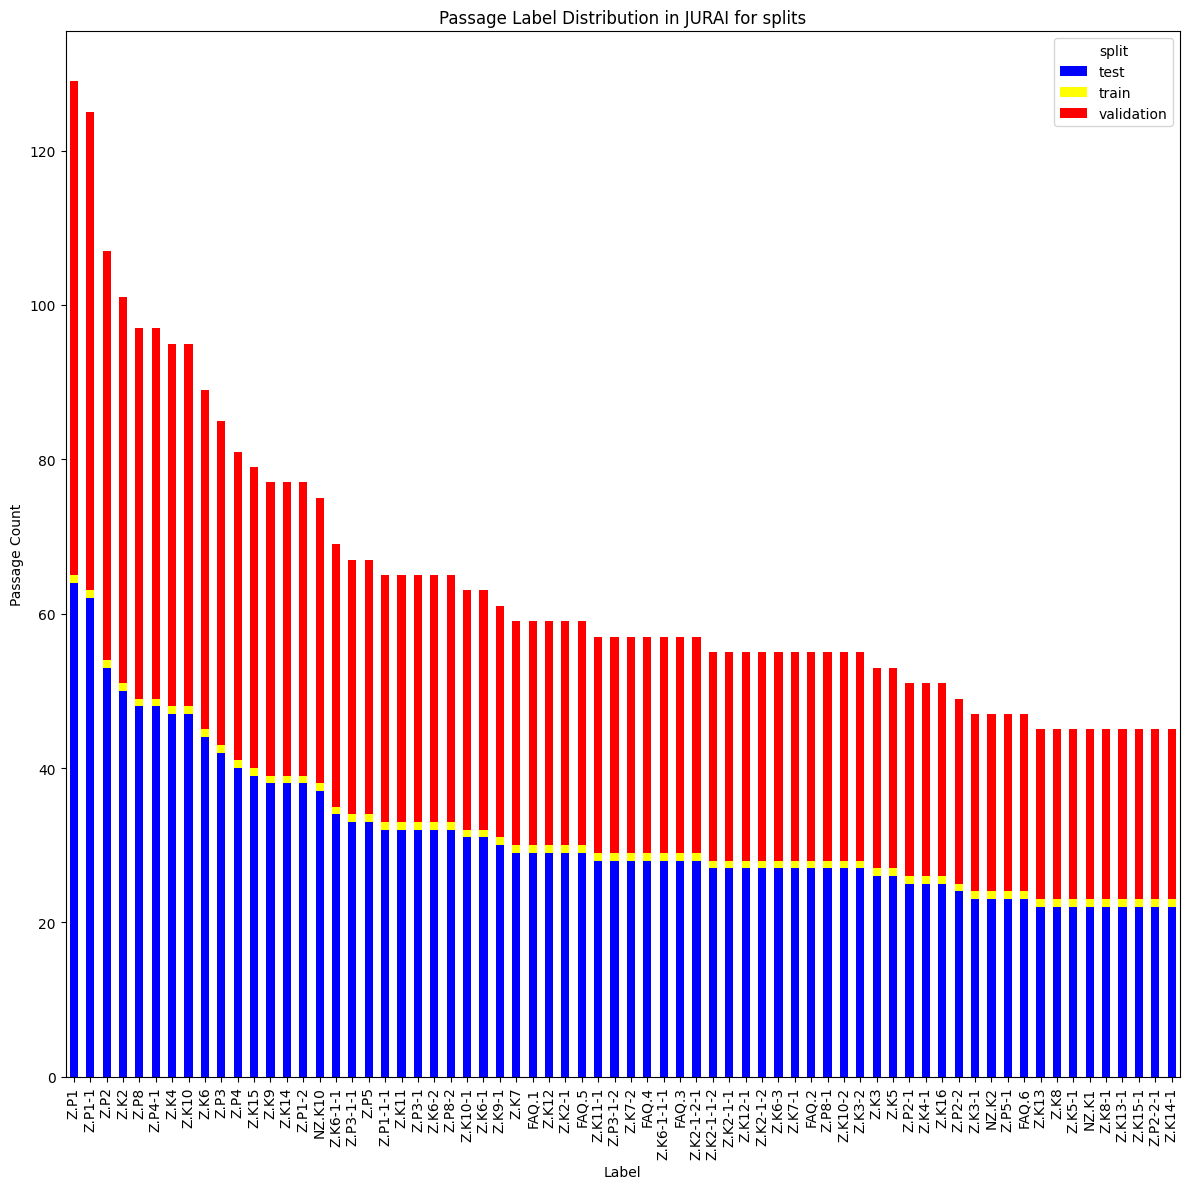

split,test,train,validation
label,,,
Z.C13,24,1,24
Z.P15-1,22,1,22
Z.C12-1,22,1,22
FAQ.2,22,1,22
FAQ.1,22,1,22


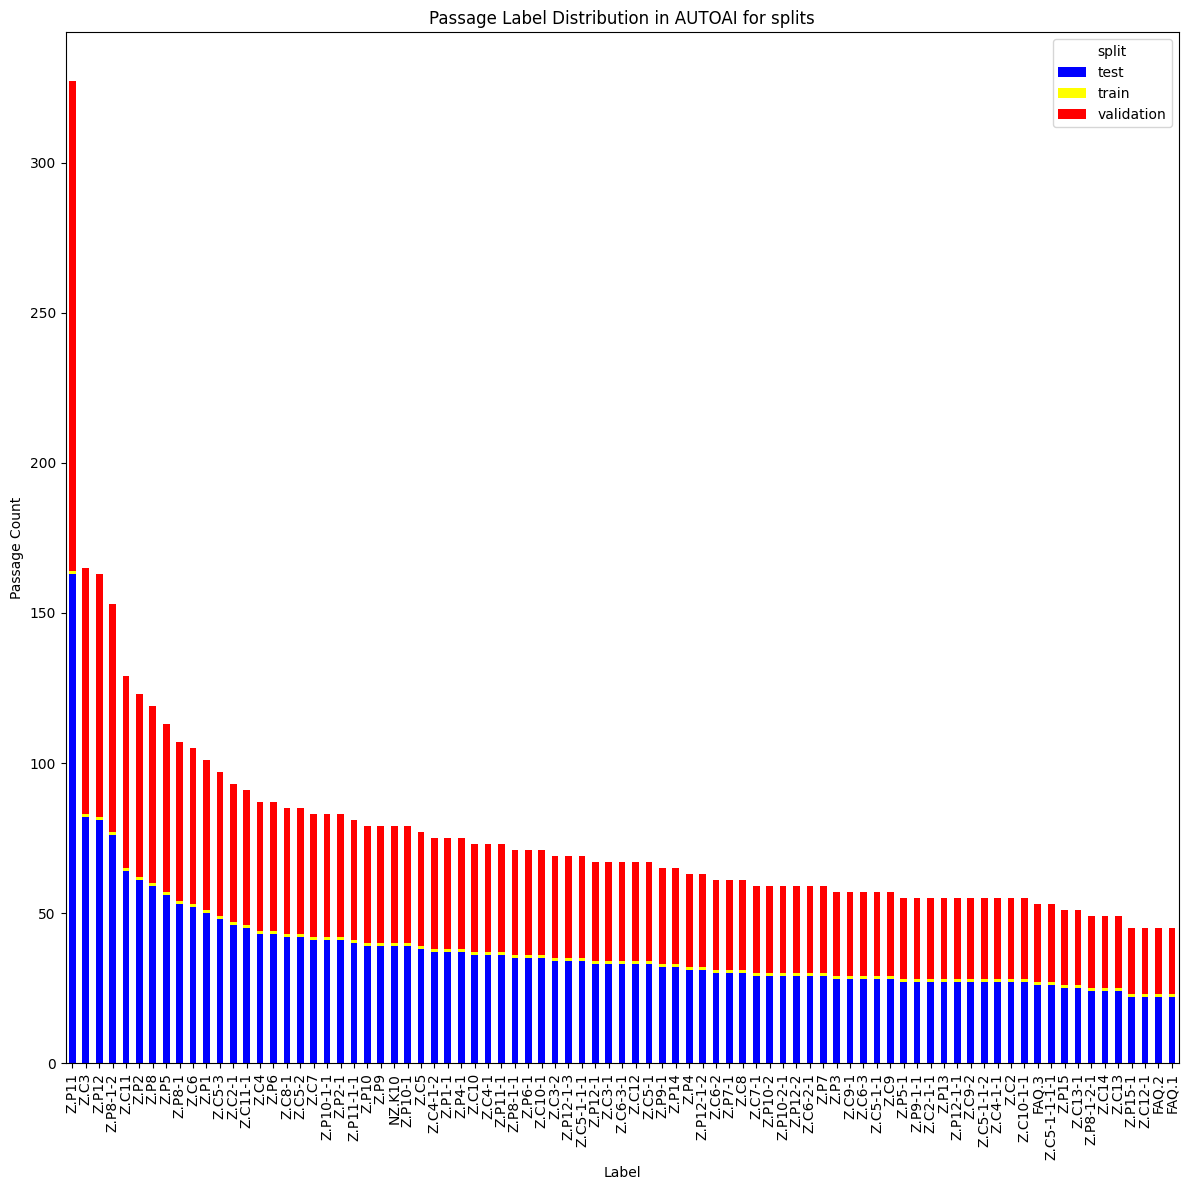

split,test,train,validation
label,,,
Z.K9-2,22,1,22
Z.P-4-1-1,22,1,22
Z.P1-2,22,1,22
Z.P1-3,22,1,22
Z.P9-2,22,1,22


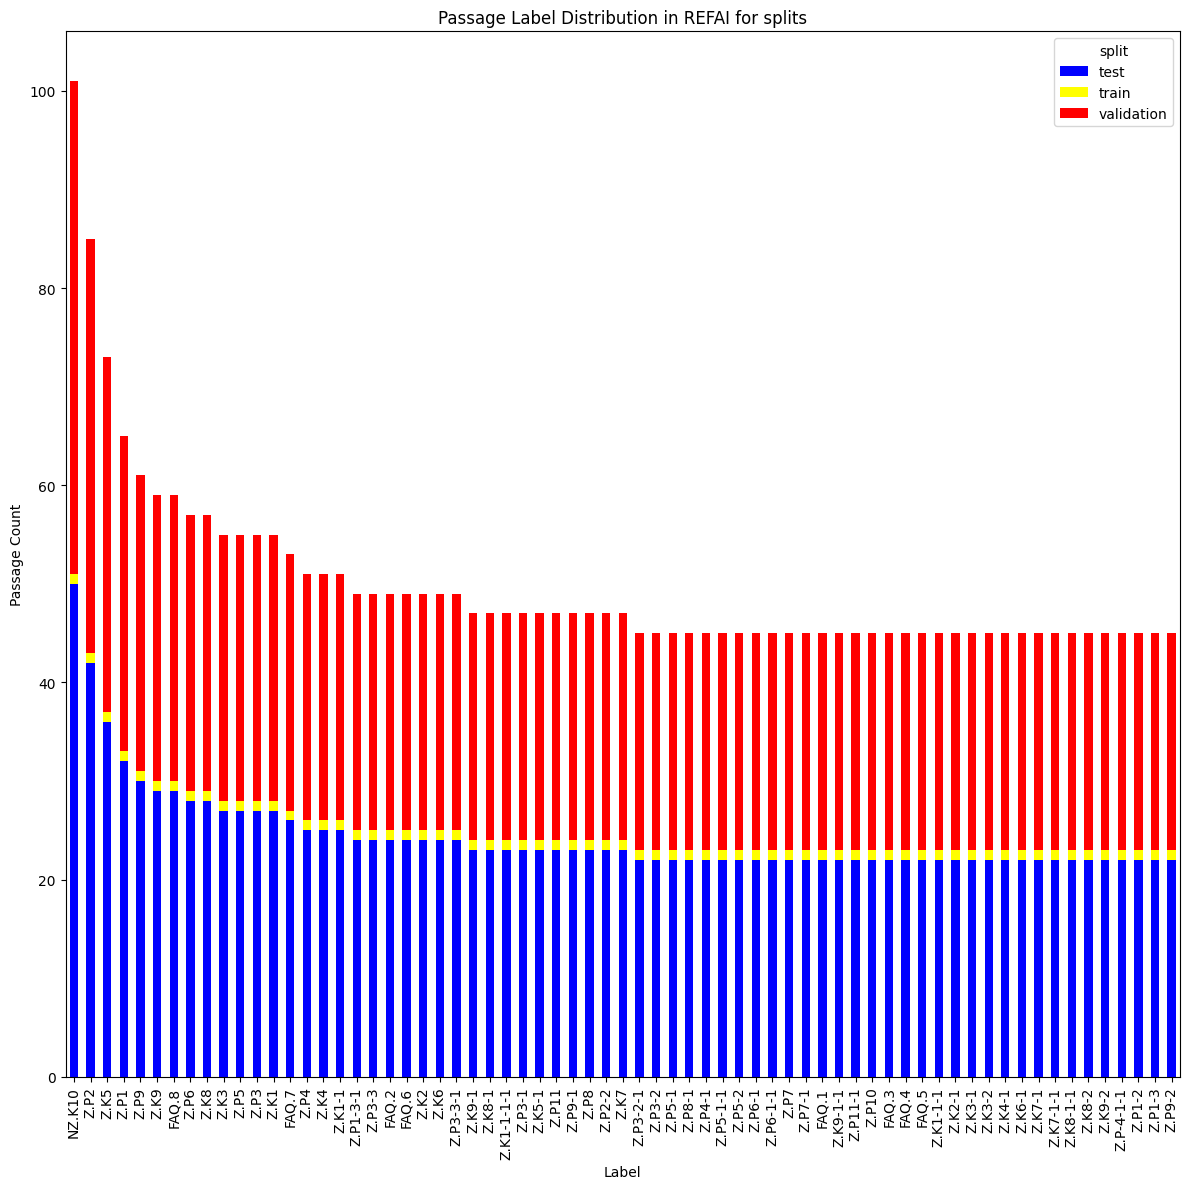

In [11]:
# Count labels per scenario and split for passages
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for passage in in_distribution_split[split]["passages"]:
        scenario = passage["discussion_scenario"]
        label_counts[split][scenario][passage["label"]] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

df = pd.DataFrame(records)

# Plot stacked bar chart per scenario
scenarios = df["scenario"].unique()
for scenario in scenarios:
    df_scenario = df[df["scenario"] == scenario]
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0).sort_values("test", ascending=False)
    display(pivot_df.tail())
    pivot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 12))
    plt.title(f"Passage Label Distribution in {scenario} for splits")
    plt.ylabel("Passage Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [12]:
def check_label_distribution(df):
    """
    Checks that any (scenario, label) pair found in 'validation' or 'test'
    also exists in 'train'. If not, prints out the faulty scenario-label pairs.
    Otherwise, confirms that the distribution is valid.
    """
    # Get all (scenario, label) pairs that appear in train (count > 0)
    train_pairs = df[(df["split"] == "train") & (df["count"] > 0)][["scenario", "label"]]
    allowed_pairs = set(zip(train_pairs["scenario"], train_pairs["label"]))

    # Find all pairs in validation/test that have count > 0
    non_train = df[df["split"].isin(["validation", "test"]) & (df["count"] > 0)].copy()

    # Mark which of these are allowed
    non_train["is_allowed"] = non_train.apply(
        lambda row: (row["scenario"], row["label"]) in allowed_pairs, axis=1
    )

    # Collect the ones that are not allowed
    faulty = non_train[~non_train["is_allowed"]]

    if len(faulty) > 0:
        print("Found scenario/label pairs in test/validation that do not appear in train:")
        print(faulty[["scenario", "label", "split", "count"]])
    else:
        print("All scenario/label pairs in test and validation are valid (they appear in train).")

check_label_distribution(dataframe)




NameError: name 'dataframe' is not defined